In [14]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

geo = "GSE111803"

In [15]:
data = pd.read_csv("../Dataset/Yao2019/data.txt", sep="\t")

In [16]:
data.columns

Index(['miRNA_ID', 'LC11.readcount', 'LC3.readcount', 'LC4.readcount',
       'LC5.readcount', 'LC6.readcount', 'NC1.readcount', 'NC2.readcount',
       'NC3.readcount', 'NC4.readcount', 'NC5.readcount', 'LC11.tpm',
       'LC3.tpm', 'LC4.tpm', 'LC5.tpm', 'LC6.tpm', 'NC1.tpm', 'NC2.tpm',
       'NC3.tpm', 'NC4.tpm', 'NC5.tpm'],
      dtype='object')

In [17]:
table = data.iloc[:, 11:].transpose()
mirnas = data.iloc[:, 0]
table

,0,1,2,3,4,5,6,7,8,9,...,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253
LC11.tpm,84.810449,35945.49515,2.019296,6601.079920,0.000000,1524.568779,438.187318,6187.124158,2.019296,448.283800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.019296,0.000000,0.000000
LC3.tpm,81.564623,24061.56385,8.718977,4780.811951,0.000000,1379.004647,408.385631,5804.307343,0.843772,542.545373,...,0.281257,0.562515,1.687544,0.562515,0.281257,0.281257,0.281257,0.281257,0.000000,0.000000
LC4.tpm,116.614493,34847.67075,8.150475,5837.621215,0.626960,1502.822259,378.683623,8105.961195,0.626960,750.470690,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC5.tpm,91.876345,28593.96015,15.312724,10165.096690,0.000000,1686.951773,579.331395,5576.383696,0.000000,201.617534,...,2.552121,2.552121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC6.tpm,81.566355,33601.82989,21.049382,11863.080790,0.000000,1524.326069,504.308107,6267.453446,3.508230,366.610067,...,0.000000,0.000000,2.631173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC1.tpm,57.658187,27294.59926,6.552067,4589.067484,0.000000,794.110478,517.613266,5409.386229,5.241653,681.414932,...,1.310413,0.000000,0.000000,0.000000,1.310413,0.000000,0.000000,0.000000,0.000000,1.310413
NC2.tpm,60.758241,23345.52549,5.523476,4267.437891,0.000000,1277.027751,407.632561,4757.922598,0.000000,269.545650,...,0.000000,0.000000,0.000000,0.000000,2.209391,4.418781,0.000000,0.000000,0.000000,1.104695
NC3.tpm,65.481015,27197.75136,2.931986,3570.181314,0.000000,1040.854941,397.446957,5409.187931,0.651552,430.350353,...,0.977329,0.325776,0.000000,0.000000,0.000000,0.325776,0.000000,0.325776,0.325776,0.000000
NC4.tpm,53.163034,25408.60776,9.968069,5724.994268,0.000000,1162.941378,348.882413,4113.489788,0.000000,624.665654,...,3.322690,0.000000,0.000000,3.322690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC5.tpm,97.619309,24992.46983,2.568929,4310.663175,0.642232,1364.743631,474.609667,4970.235744,1.284465,880.500479,...,1.284465,0.642232,0.642232,0.000000,0.642232,0.642232,0.000000,0.000000,0.000000,0.000000


In [18]:
controls = np.array(["NC" in c for c in table.index])
sick = 1 - controls

### Mean-variance-plot

In [19]:
np.mean(table)

0          79.111205
1       28528.947349
2           8.279538
3        6171.003470
4           0.126919
            ...     
1249        0.566805
1250        0.028126
1251        0.262633
1252        0.032578
1253        0.241511
Length: 1254, dtype: float64

In [20]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [21]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

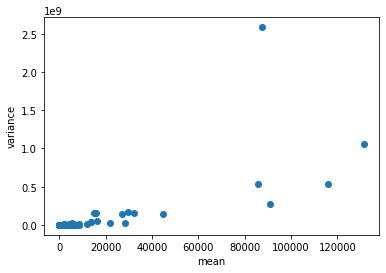

In [22]:
mean_variance_plot(table)

### Log transformation

In [23]:
log_table = np.log2(table + 1)

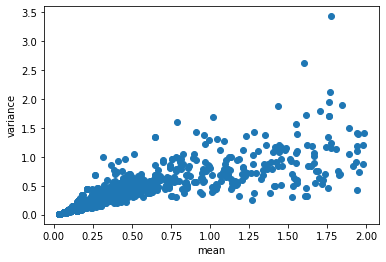

In [24]:
mean_variance_plot(log_table.loc[:, log_table.mean() < 2])

In [25]:
mask = log_table.mean() < 0.75
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Standardizing

In [26]:
norm_log_table = log_table - np.mean(log_table)

In [27]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

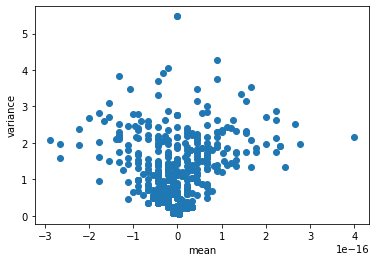

In [28]:
mean_variance_plot(norm_log_table)

In [29]:
norm_log_table.isna().sum().sum()

0

### PCA

In [30]:
pca = decomposition.PCA(n_components=10)

In [31]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [32]:
pca.explained_variance_ratio_

array([1.93587850e-01, 1.47469445e-01, 1.41358345e-01, 1.20323975e-01,
       1.14692944e-01, 1.03216882e-01, 7.71554485e-02, 5.24107200e-02,
       4.97843904e-02, 8.89808254e-33])

In [33]:
components = pca.transform(norm_log_table)

In [34]:
components

array([[-9.25371889e+00, -1.61180109e+01,  1.00083239e+01,
        -8.58765613e+00, -1.29133197e+01, -9.27763618e-01,
         1.96767163e+00, -5.79492713e-01,  3.11841908e-01,
         1.66533454e-15],
       [-2.71297767e+00,  1.82170618e+00, -2.25063871e+00,
         1.56561320e+00,  4.05783210e+00, -1.18646422e+00,
         3.88716325e+00, -3.09746808e+00,  1.47893926e+01,
        -1.11022302e-16],
       [-3.19450175e+00,  2.85112442e+00, -1.19076486e+00,
        -1.10151308e+00,  7.34785661e+00, -3.53491632e+00,
         1.54715260e+01, -4.20462462e+00, -6.64451284e+00,
        -3.16413562e-15],
       [ 1.06050573e+01,  1.21799133e+01,  2.14148480e+01,
         3.57144551e+00, -7.47222707e-01,  2.67285366e+00,
        -1.54888971e+00,  1.66556528e-01, -4.14090184e-01,
        -4.74204009e-14],
       [-8.51112596e+00,  1.79259046e+01, -1.02861454e+01,
        -6.69983559e+00, -1.18554035e+01,  1.71810132e+00,
        -2.35760355e+00,  8.73761748e-01, -1.24012239e+00,
         7.

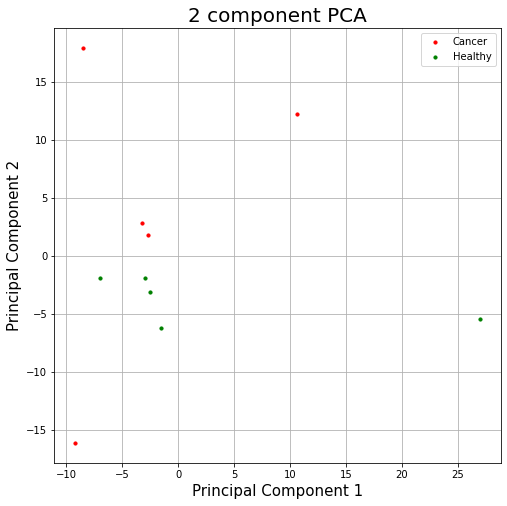

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [36]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

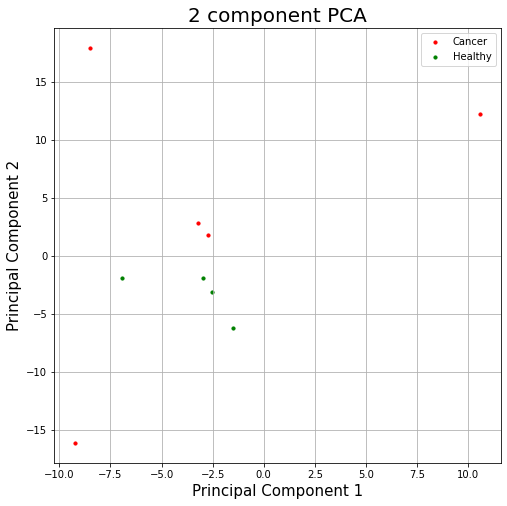

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [39]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


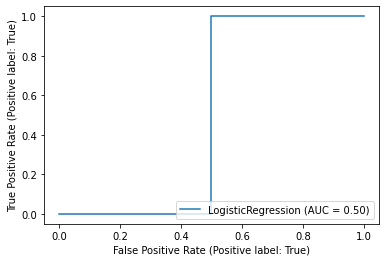

In [40]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [41]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [42]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


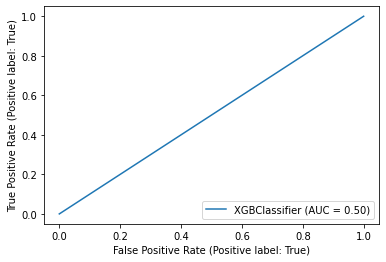

In [43]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [44]:
mirnas[:10]

4       hsa-let-7c-3p
13      hsa-let-7g-3p
19     hsa-miR-101-5p
32       hsa-miR-1179
34       hsa-miR-1183
37    hsa-miR-1185-5p
38       hsa-miR-1193
39       hsa-miR-1197
40     hsa-miR-122-3p
41    hsa-miR-1224-5p
Name: miRNA_ID, dtype: object

In [45]:
from Scripts import converters

In [46]:
sequences = converters.canonical_to_seq(mirnas, True)

In [47]:
sequences = np.array(sequences)

In [48]:
mirnas[sequences == None]

1190    novel_210
1191    novel_217
1192    novel_218
1193    novel_232
1194    novel_240
1195    novel_241
1196    novel_246
1197    novel_259
1198    novel_261
1199    novel_271
1200    novel_272
1201    novel_273
1202    novel_274
1203    novel_290
1204    novel_292
1205    novel_299
1207    novel_321
1209    novel_357
1210    novel_383
1211    novel_386
1214    novel_408
1215    novel_421
1216    novel_422
1217    novel_433
1218    novel_434
1219    novel_441
1220    novel_451
1221    novel_453
1222    novel_456
1223    novel_458
1224    novel_479
1225    novel_490
1226    novel_491
1227    novel_503
1230    novel_521
1231    novel_522
1232    novel_528
1235    novel_545
1236    novel_557
1238    novel_595
1239    novel_603
1240    novel_615
1241    novel_620
1242    novel_622
1243    novel_635
1245    novel_649
1246    novel_650
1247    novel_653
1248    novel_659
1249    novel_670
1250    novel_672
1251    novel_677
1252    novel_692
1253    novel_699
Name: miRNA_ID, dtype: objec

In [49]:
mask = sequences != None
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [50]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CUGUACAACCUUCUAGCUUUCC,CUGUACAGGCCACUGCCUUGC,CAGUUAUCACAGUGCUGAUGCU,AAGCAUUCUUUCAUUGGUUGG,CACUGUAGGUGAUGGUGAGAGUGGGCA,AGAGGAUACCCUUUGUAUGUU,GGGAUGGUAGACCGGUGACGUGC,UAGGACACAUGGUCUACUUCU,AACGCCAUUAUCACACUAAAUA,GUGAGGACUCGGGAGGUGG,...,AAUGGCUGUCCGUAGUAUGGUC,UGCAACGAACCUGAGCCACUGA,CACUGUGUCCUUUCUGCGUAG,UGUGCGCAGGGAGACCUCUCCC,AUCCGCGCUCUGACUCUCUGCC,AAGGCAGGGCCCCCGCUCCCC,CUGACUGUUGCCGUCCUCCAG,AAUCAUGUGCAGUGCCAAUAUG,CAAGCUCGCUUCUAUGGGUCUG,cancer
LC11.tpm,-0.286275,-1.062877,-0.583200,-0.557371,-0.369229,-0.295109,-0.255625,-1.344051,-0.749211,-0.661839,...,-0.226643,-0.829249,-1.088884,-1.489055,-0.410073,-1.018511,2.233208,-0.737021,-0.141777,1
LC3.tpm,-0.286275,1.132858,0.138749,0.742666,-0.369229,-0.295109,0.466325,-0.622101,-0.749211,0.638197,...,-0.226643,-0.829249,-1.088884,1.390763,-0.410073,0.763667,-0.263715,-0.737021,-0.141777,1
LC4.tpm,1.131493,-1.062877,0.834567,-0.557371,-0.369229,-0.295109,-0.255625,2.311694,-0.749211,1.705425,...,-0.226643,1.538015,-1.088884,-0.071287,-0.410073,1.348752,-0.985664,-0.737021,1.275991,1
LC5.tpm,-0.286275,2.629410,3.109087,-0.557371,3.323058,-0.295109,-0.255625,-1.344051,-0.749211,-0.661839,...,-0.226643,-0.829249,-1.088884,2.203232,-0.410073,-1.018511,-0.985664,-0.737021,-0.141777,1
LC6.tpm,-0.286275,0.771419,-0.583200,1.276926,-0.369229,2.655983,1.578672,0.490246,-0.749211,2.289253,...,-0.226643,-0.829249,-1.088884,1.462038,1.424224,-1.018511,-0.985664,-0.737021,-0.141777,1


In [51]:
norm_log_table.to_csv("../TransformedData/Yao2019.csv", index=False)